# Simple Mouse Model

## Goal
This is a 1 hidden layer neural network that uses a form of Hebbian learning on the final set of weights between the hidden layer and the output in order to recreate the initial learning behaviour of mice during tactile discrimination.  This implementation is meant to test the weight update equation used by Zhang, et. al. in their work published in early 2018 [A neural network model for the orbitofrontal cortex and task space acquisition during reinforcement learning](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1005925&type=printable).

## Mathematics
Below are the mathematical formulations from Zhang, et. al. With the exception of the weight update equation, the other equations have been simplified as much as possible in order to fit a single layer feed forward neural network. <br>

The network has N nodes whose activation value $x$ is represented by 
\begin{align}
\frac{1}{\tau} \frac{dx}{dt}= -x_i + w_i^{(input)}I + \sigma_{noise}dW_i \\
x(t + 1) = x(t) + \dot{x}(t)\Delta t
\end{align}

Where $dW_i$ stands for white noise sampled from a uniform distribution [0, 1] and $\sigma_{noise}$ is its variance.  The output of each neuron $i$, however, will be determined by its firing rate $y_i$, relative to a $y_{min}=0$, $y_{max}=1$ and baseline firing rate $y_0 = 0.1$.  It is determined by the following piecewise function:
\begin{align}
y=   \left\{
\begin{array}{ll}
      y_0 + y_0 tanh(x/y_0) & x \leq 0   \\
      y_0 + (y_{max} - y_0)*tanh(\frac{x}{y_{max}- y_0}) & x > 0 \\
\end{array} 
\right.
\end{align}

The contributions of each node are then summed to $v_k$.   $p_k$ is then determined by applying the sigmoid function on $v_k$.  $p_k$ is the expected reward $E[r_k]$ from taking action $a_k$<br>
\begin{align}
v_k = \sum_{i=1}^N w_{ik}^{(out)} * y_i \\
p_k = E[r_k] = \frac{e^{-\beta v_k}}{\sum_i e^{-\beta v_i}}
\end{align}

The final output elements $z_k$ is either 1 with probability $p_k$ or 0 with probability $1 - p_k$  The weighted random choice in this experiment is between two actions $a_k$:  $a_1=<0, 1>$  and $a_2=<1,0>$, where $z_1 = 1$ means $a_1$ was chose, and $z_2=1$ means $a_2$ was chosen. 

The weights on the output layer ($w_{out}$) are the only ones that are plastic.  These are only updated on the same timestep that the reward $r$ is administered because the mice do not receive any information nor feedback when they refuse to lick, regardless of the texture presented.  The update is relative to the particular decision taken $z_k$ and whether a given neuron $y_i$ had a firing rate greater than the threshold $y_{th}$.
\begin{align}
\Delta w^{(out)} = \eta (r - E[r]) (y_i - y_{th}) z_k \\
w^{(out)}(n + 1) = w^{(out)}(n) + \Delta w^{(out)} \\
\end{align}
Finally, the weights are normalized after each update:
\begin{align}
w^{(out)}(n) = \frac{w^{(out)}(n)}{\sqrt{\sum_{i=1}^N ||w^{(out)}(n)||^2}}
\end{align}

In [402]:
# Imports.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.signal import butter, lfilter, freqz
import seaborn as sns
sns.set()

In [403]:
# Experimental parameters.

num_trials = 500 # Original number: 1000
StopTrainingTrials = 5000
numReversed = 100
reinforcedSchedule = 1 # determined or prob
withRF = 1  # reward feedback
numMod = 1
detail = 0
REinitial = 1
simutan= 1
blocking = 0 # 0:no block, 1: random block,  2:A block,  3: AR block 

# set the time
dt = 0.001
start = 0.2    # upon time of stimulus
sdur = 0.5    # duration of the stimulus
inter = 0   # interval between stimulus and reward
rdur = 0.5    # duration of reward input
delay = 0.2   # delay before decision
intertrial = 0
tau = 0.1 # time constant 

In [404]:
# Model parameters from OFC paper for the reversal learning task

reservoir_network_params = {
    'tau'         : 0.1,         # 100ms.
    'dt'          : 0.001,       # 1ms.
    'network gain': 2,           # g
    'training threshold': 0.2,   # y_th
    'temp parameter'    : 4,     # B (beta)
    'learning rate'     : 0.001, # n (eta)
    'max firing rate'   : 1,     # y_max
    'base firing rate'  : 0.1,   # y_0
    'noise gain'  : 0.01,        # sigma_noise
    'initial noise gain': 0.01,  # sigma_ini
    'input gain'  : 4,           # g_IR        gain input -> reservoir
    'input prob'  : 0.2,         # p_IR        prob input -> reservoir
    'hidden layer prob' : 0.1,   # p           Probability of connection in hidden layer
}

In [405]:
# Helper functions.

def softmax(x, beta):
    e = np.exp(-beta * x)
    return e / e.sum()
  
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
  
def gaussian(mu,s2):
    return np.exp(-mu**2/2/s2) / np.sqrt(2 * np.pi * s2)

def smooth(x1, x2, y1, s2):
    N2 = len(x2)
    y2 = np.zeros(N2)

    # Check that the new data range does not exceed the old one
    rangeX1 = [np.min(x1), np.max(x1)]
    rangeX2 = [np.min(x2), np.max(x2)]

    for i2 in range(x2.size):
        w_ker = gaussian(x2[i2] - x1, s2)
        w_ker /= np.sum(w_ker)
        y2[i2] = w_ker.dot(y1)

    return y2

In [406]:
# Single layer feedforward neural network using OFC paper's equations.
class SingleLayerFeedforwardNet_v1(object):
    def __init__(self, params, nodes=500, input_dim=2, output_dim=2, reward_dim=1):
        self.output_dim = output_dim
        self.params = params
        self.init_input_weights(input_dim, nodes)
        self.init_neurons(nodes)
        self.init_output_weights(nodes, output_dim)
        self.exp_r = np.zeros(output_dim)
        self.z = np.zeros(output_dim)

    def init_input_weights(self, input_dim, nodes):
        std_dev = self.params['input gain']  # The paper uses a variance of g_IR^2
        w_input = np.random.normal(loc=0.0, scale=std_dev, size=(input_dim, nodes))
        p_IR = self.params['input prob']
        indices = np.random.choice([0, 1], size=w_input.shape, p=[1 - p_IR, p_IR]) 
        self.w_input = np.multiply(w_input, indices)

    def init_neurons(self, nodes):
        std_dev = self.params['initial noise gain'] # The paper uses a variance of sigma_ini^2
        x = np.random.normal(loc=0.0, scale=std_dev, size=nodes)
        y = np.ones(nodes) * self.params['base firing rate']
        self.x = x
        self.y = y

    def init_output_weights(self, nodes, output_dim):
        W = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
        # According to the paper: normalize according to the squared sum of the weights for each output node.
        W = W/np.sqrt(np.square(W).sum(axis=0))
        self.output_weights = W
    
    def step(self, I=0):
        if np.array_equal(I, 0):
            I = np.zeros(self.w_input.shape[0])

        tau = self.params['tau']
        dt = self.params['dt']
        g = self.params['network gain']
        sigma_noise = self.params['noise gain']
        y_0 = self.params['base firing rate']
        y_max = self.params['max firing rate']
        
        white_noise = np.random.randint(0, high=(1 + 1), size=self.x.size)
        
        dx_dt = 1/tau * (-self.x + np.dot(self.w_input.T, I) 
                         + sigma_noise * white_noise)
        self.x += dx_dt * dt
        
        y_conditions =[self.x <= 0, self.x > 0]
        y_functions =[
            lambda x: y_0 + y_0 * np.tanh(x/y_0),
            lambda x: y_0 + (y_max - y_0) * np.tanh(x/(y_max - y_0))
        ]
        self.y = np.piecewise(self.x, y_conditions, y_functions)
        
        v_k = np.dot(self.y, self.output_weights)
        beta = self.params['temp parameter']
        p_k = softmax(v_k, beta)
        
        #self.z = np.greater_equal(p_k, p_k.max()).astype(float)
        choice_idx = np.random.choice(p_k.shape[0], p=p_k)
        self.z = np.zeros(p_k.shape)
        self.z[choice_idx] = 1
         
            
        self.exp_r = p_k
        return self.z

    def receive_reward(self, r):
        self.update_weights(r)

    def update_weights(self, r):
        row_vec = self.y - self.params['training threshold']
        col_vec = (r - self.exp_r) * self.z
        delta_w = self.params['learning rate'] * np.outer(row_vec, col_vec)
        self.output_weights += delta_w

        # Normalize weights
        self.output_weights /= np.linalg.norm(self.output_weights)

    def get_output(self, exp=False):
        if exp:
            return self.z, self.exp_r
        else:
            return self.z

In [407]:
# Experiment function.

def simple_experiment(I, T=1000, num_trials=3000, net=None, contingency=None):
    r_hist = []
    decision_hist = []
    exp_hist = []
    r = 0

    for trial in range(num_trials):
        index = np.random.randint(I.shape[0])
        text_input = I[index]
        exp_output = contingency[index]
        
        decision = 0
        expectation = 0

        for ms in range(T):
            # Initial rest period (0 - 200ms) of trial
            if ms < (T * delay):
                net.step()
                continue

            # Apply input for the trial (200ms - 700ms)
            if 200 <= ms <= 700:
                net.step(text_input)
                continue

            # Measure output of the network (900ms)
            if ms == 900:
                net.step()
                decision, expectation = net.get_output(exp=True)
                r = int(np.array_equal(decision, exp_output))
                net.receive_reward(r)
                #decision_hist += [decision]
                #exp_hist += [expectation]
                continue

            if ms > 900:
#               net.receive_reward(r)
                net.step()
                continue
            
            # If nothing needs to happen, move forward a timestep.
            net.step()
      
        r_hist += [r]
        decision_hist += [decision]
        exp_hist += [expectation]
    
    r_hist = np.array(r_hist)
    decision_hist = np.array(decision_hist)
    exp_hist = np.array(exp_hist)
    return r_hist, decision_hist, exp_hist

In [408]:
# Inputs.
I_1 = np.array([1, 0])
I_2 = np.array([0, 1])

I = np.array([I_1, I_2])


# Outpus.
A_1 = np.array([1, 0])
A_2 = np.array([0, 1])


# Expected outputs.
I2A_1 = np.array([A_1, A_2])
I2A_2 = np.array([A_2, A_1])

In [409]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = SingleLayerFeedforwardNet_v1(reservoir_network_params)

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=num_trials, net=net, contingency=I2A_1)

Learning rate = 0.001


In [410]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

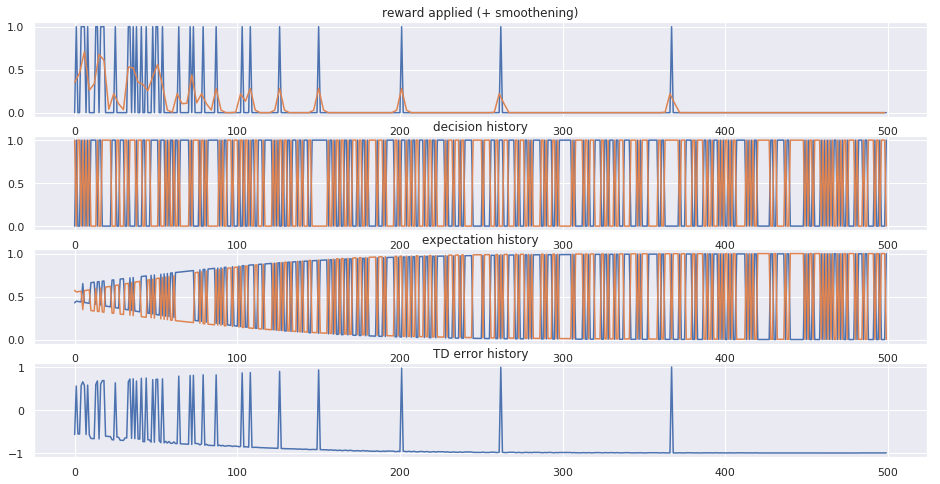

In [411]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

In [412]:
# Reverse contingency.
r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=num_trials, net=net, contingency=I2A_2)

In [413]:
# Post-processing (reversal).

t_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), t_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

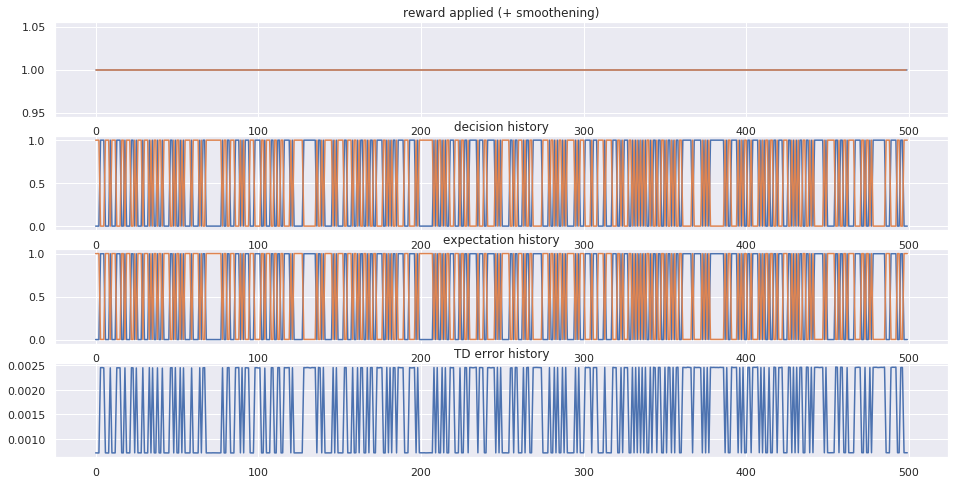

In [414]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(t_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

## Further Simplifications

### No spiking neurons
Instead of calculating a firing rate, I will use the value of each node $x$ directly in the calculation of $v_k$. 
The equations describing this are as follow:

\begin{align}
\frac{1}{\tau} \frac{dx}{dt}= -x_i + w_i^{(input)}I + \sigma_{noise}dW_i \\
x(t + 1) = x(t) + \dot{x}(t)\Delta t
\end{align}

---

\begin{align}
v_k = \sum_{i=1}^N w_{ik}^{(out)} * x_i \\
p_k = E[r_k] = \frac{e^{-\beta v_k}}{\sum_i e^{-\beta v_i}}
\end{align}

---

\begin{align}
z_k=   \left\{
\begin{array}{ll}
      Pr(z_k=1) = p_k   \\
      Pr(z_k=0) = 1-p_k  \\
\end{array} 
\right.
\end{align}

---
In the case of the weight update, a new value $x_{th}$ will likely need to be calculated.  For the moment, I will stick to the original threshold $y_{th}$.
\begin{align}
\Delta w^{(out)} = \eta (r - E[r]) (x_i - y_{th}) z_k \\
w^{(out)}(n + 1) = w^{(out)}(n) + \Delta w^{(out)} \\
\end{align}

\begin{align}
w^{(out)}(n) = \frac{w^{(out)}(n)}{\sqrt{\sum_{i=1}^N ||w^{(out)}(n)||^2}}
\end{align}

In [415]:
# Feedforward network without spiking neurons.
class SingleLayerFeedforwardNet_v2(SingleLayerFeedforwardNet_v1):

    def step(self, I=0):
        if np.array_equal(I, 0):
            I = np.zeros(self.w_input.shape[0])

        tau = self.params['tau']
        dt = self.params['dt']
        g = self.params['network gain']
        sigma_noise = self.params['noise gain']
        y_0 = self.params['base firing rate']
        y_max = self.params['max firing rate']
        
        white_noise = np.random.randint(0, high=(1 + 1), size=self.x.size)
        
        dx_dt = 1/tau * (-self.x + np.dot(self.w_input.T, I) 
                         + sigma_noise * white_noise)
        self.x += dx_dt * dt
                
        v_k = np.dot(self.x, self.output_weights)
        beta = self.params['temp parameter']
        p_k = softmax(v_k, beta)
        
        #self.z = np.greater_equal(p_k, p_k.max()).astype(float)
        choice_idx = np.random.choice(p_k.shape[0], p=p_k)
        self.z = np.zeros(p_k.shape)
        self.z[choice_idx] = 1
         
            
        self.exp_r = p_k
        return self.z

    def update_weights(self, r):
        row_vec = self.x - self.params['training threshold']
        col_vec = (r - self.exp_r) * self.z
        delta_w = self.params['learning rate'] * np.outer(row_vec, col_vec)
        self.output_weights += delta_w
          
        # Normalize weights
        self.output_weights /= np.linalg.norm(self.output_weights)


In [416]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = SingleLayerFeedforwardNet_v2(reservoir_network_params)

r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=num_trials, net=net, contingency=I2A_1)

Learning rate = 0.001


In [417]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

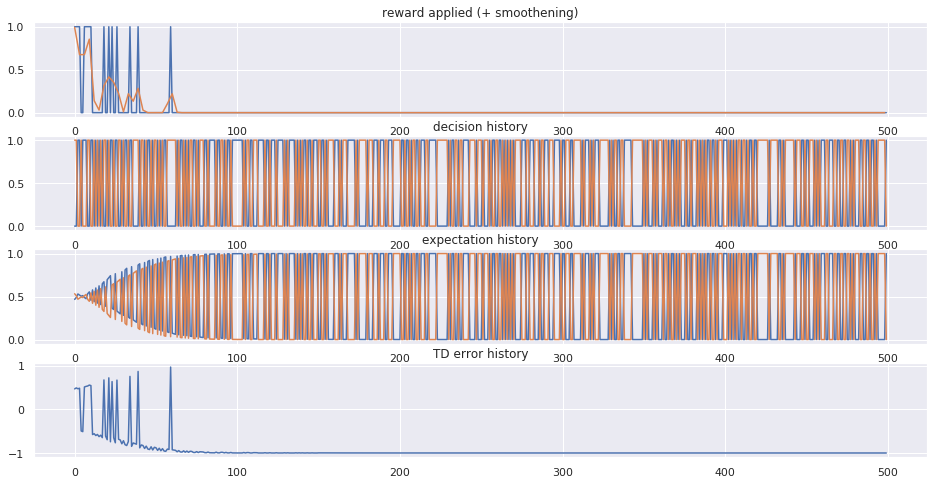

In [418]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(t_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

In [419]:
# Reverse contingency.
r_hist, decision_hist, exp_hist = simple_experiment(
    I, T=1000, num_trials=num_trials, net=net, contingency=I2A_2)

In [420]:
# Post-processing (reversal).

t_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), t_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

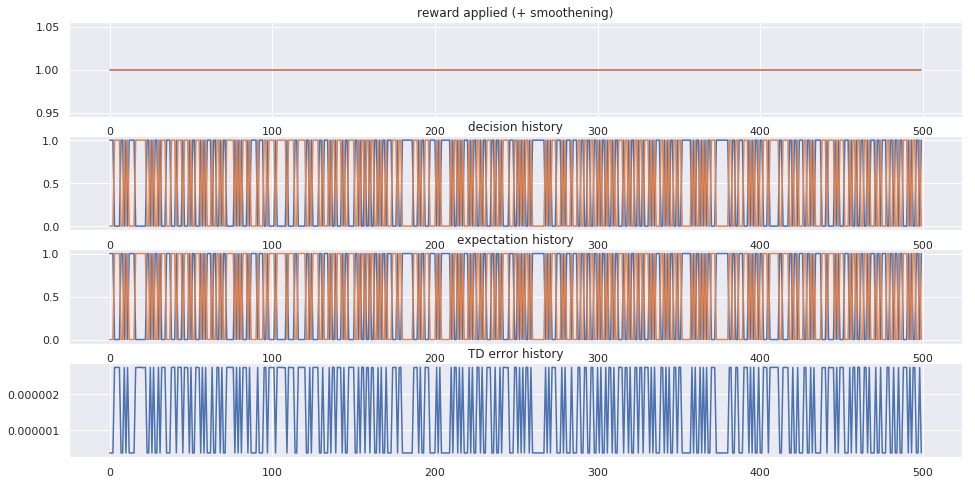

In [421]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(t_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

## No temporal dynamics
I will drop the differential equation describing $\frac{dx}{dt}$ and make $x$ purely a feedforward function of the input without the white noise term.

\begin{align}
x_i = w_i^{(input)}I
\end{align}

---

\begin{align}
v_k = \sum_{i=1}^N w_{ik}^{(out)} * x_i \\
p_k = E[r_k] = \frac{e^{-\beta v_k}}{\sum_i e^{-\beta v_i}}
\end{align}

---

\begin{align}
z_k=   \left\{
\begin{array}{ll}
      Pr(z_k=1) = p_k   \\
      Pr(z_k=0) = 1-p_k  \\
\end{array} 
\right.
\end{align}

---
In the case of the weight update, a new value $x_{th}$ will likely need to be calculated.  For the moment, I will stick to the original threshold $y_{th}$.
\begin{align}
\Delta w^{(out)} = \eta (r - E[r]) (x_i - y_{th}) z_k \\
w^{(out)}(n + 1) = w^{(out)}(n) - \Delta w^{(out)} \\
\end{align}

\begin{align}
w^{(out)}(n) = \frac{w^{(out)}(n)}{\sqrt{\sum_{i=1}^N ||w^{(out)}(n)||^2}}
\end{align}

In [422]:
# Feedforward network without temporal dynamics.
class SingleLayerFeedforwardNet_v3(SingleLayerFeedforwardNet_v2):

    def step(self, I=0):
        if np.array_equal(I, 0):
            I = np.zeros(self.w_input.shape[0])

        tau = self.params['tau']
        dt = self.params['dt']
        g = self.params['network gain']
        sigma_noise = self.params['noise gain']
        y_0 = self.params['base firing rate']
        y_max = self.params['max firing rate']
        
        white_noise = np.random.randint(0, high=(1 + 1), size=self.x.size)
        
        self.x = np.dot(self.w_input.T, I)
                
        v_k = np.dot(self.x, self.output_weights)
        beta = self.params['temp parameter']
        p_k = softmax(v_k, beta)
        
        #self.z = np.greater_equal(p_k, p_k.max()).astype(float)
        choice_idx = np.random.choice(p_k.shape[0], p=p_k)
        self.z = np.zeros(p_k.shape)
        self.z[choice_idx] = 1
         
            
        self.exp_r = p_k
        return self.z

In [423]:
# Experiment function without temporal dynamics.

def discrete_experiment(I, num_trials=3000, net=None, contingency=None):
    r_hist = []
    decision_hist = []
    exp_hist = []
    r = 0

    for trial in range(num_trials):
        index = np.random.randint(I.shape[0])
        text_input = I[index]
        exp_output = contingency[index]
        
        decision = 0
        expectation = 0

        # Provide input.
        net.step(text_input)
        
        # Measure output of the network
        decision, expectation = net.get_output(exp=True)
        r = int(np.array_equal(decision, exp_output))
        net.receive_reward(r)

        # Record activity.
        r_hist += [r]
        decision_hist += [decision]
        exp_hist += [expectation]
    
    r_hist = np.array(r_hist)
    decision_hist = np.array(decision_hist)
    exp_hist = np.array(exp_hist)
    return r_hist, decision_hist, exp_hist

In [424]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = SingleLayerFeedforwardNet_v3(reservoir_network_params)

r_hist, decision_hist, exp_hist = discrete_experiment(
    I, num_trials=num_trials, net=net, contingency=I2A_1)

Learning rate = 0.001


In [425]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

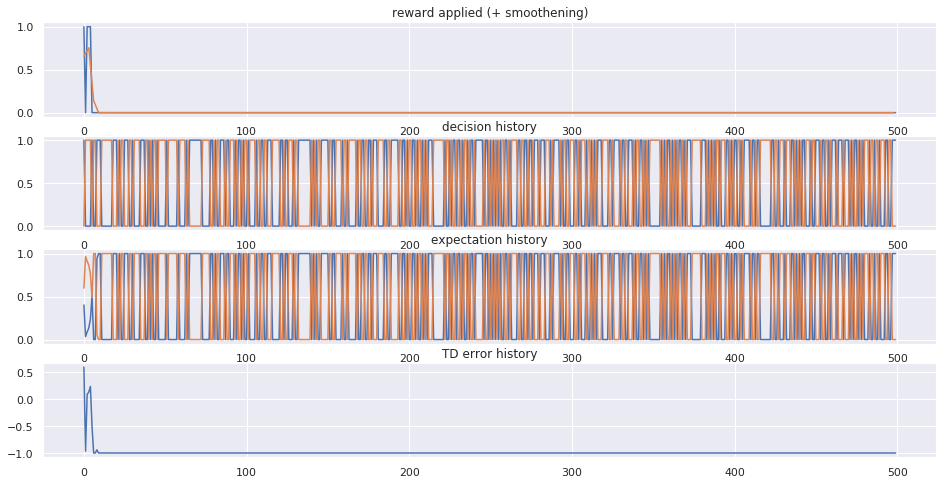

In [426]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(t_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

In [427]:
# Reverse contingency.
r_hist, decision_hist, exp_hist = discrete_experiment(
    I, num_trials=num_trials, net=net, contingency=I2A_2)

In [428]:
# Post-processing (reversal).

t_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), t_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

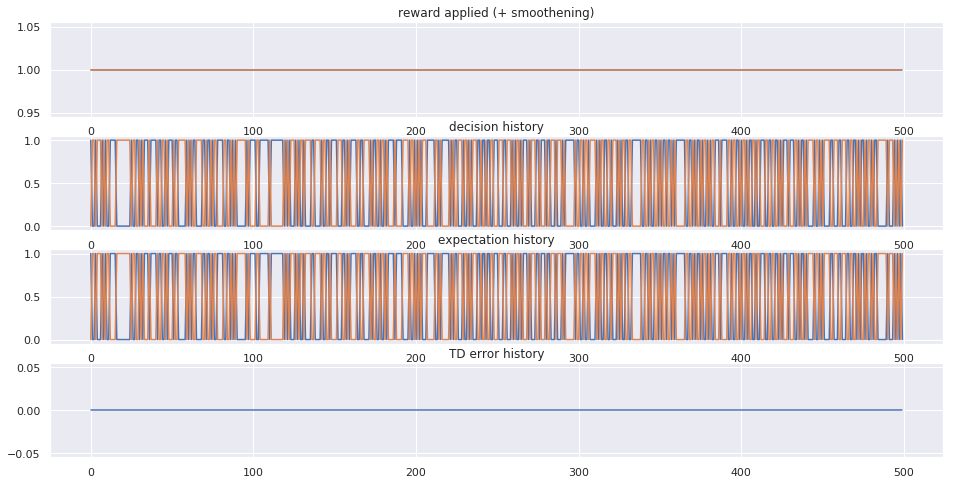

In [429]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(t_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

## Slower learning rate
It seems the weights may be updating too harshly for the model to exhibit  a learning curve over the course of many trials.  I will drastically reduce the learning rate as an attempt at provoking such a curve.

In [430]:
# Initial learning experiment.

print("Learning rate = 0.00001")
net = SingleLayerFeedforwardNet_v3(reservoir_network_params)
net.params['learning rate'] = 0.00001

r_hist, decision_hist, exp_hist = discrete_experiment(
    I, num_trials=num_trials*2, net=net, contingency=I2A_1)

Learning rate = 0.00001


In [431]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

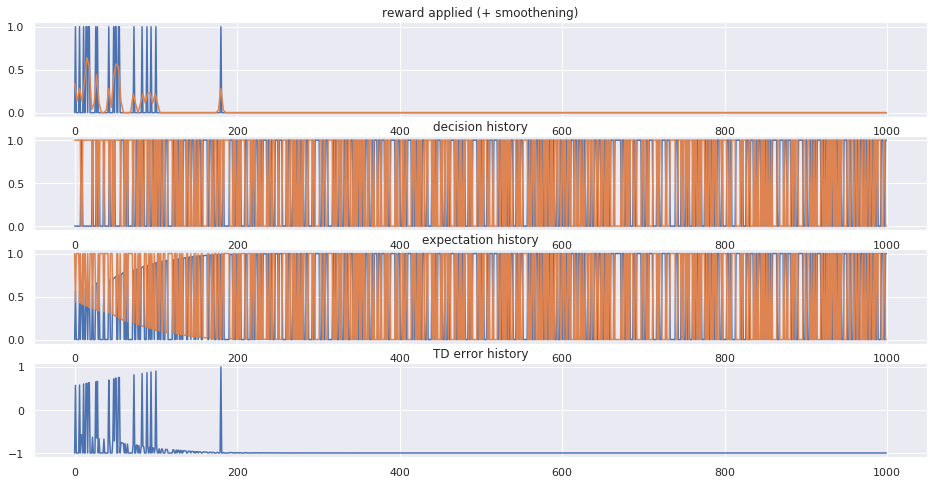

In [432]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

In [433]:
# Reverse contingency.
r_hist, decision_hist, exp_hist = discrete_experiment(
    I, num_trials=num_trials*2, net=net, contingency=I2A_2)

In [434]:
# Post-processing (reversal).

time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

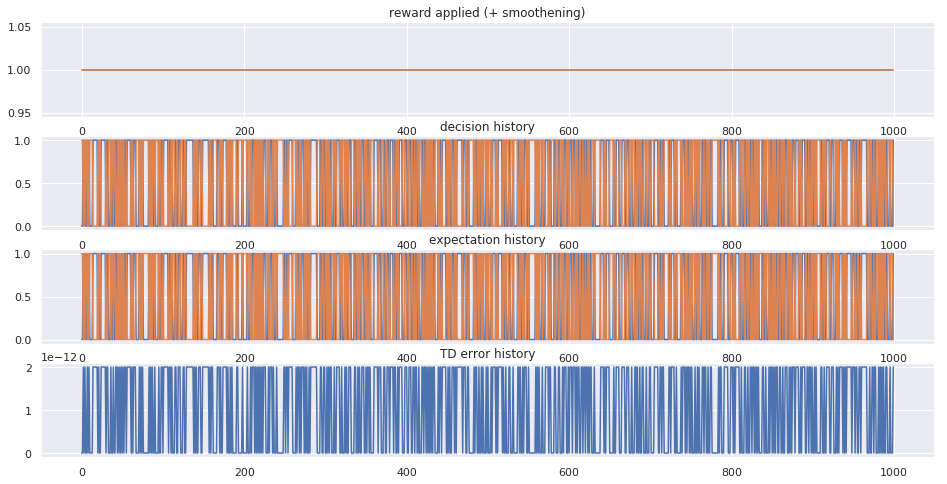

In [435]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()

## No weight normalization

In [439]:
# Feedforward network without weight normalization.
class SingleLayerFeedforwardNet_v4(SingleLayerFeedforwardNet_v3):    

    def init_output_weights(self, nodes, output_dim):
        W = np.random.normal(loc=0.0, scale=1, size=(nodes, output_dim))
        self.output_weights = W
        
    def update_weights(self, r):
        row_vec = self.x - self.params['training threshold']
        col_vec = (r - self.exp_r) * self.z
        delta_w = self.params['learning rate'] * np.outer(row_vec, col_vec)
        self.output_weights += delta_w
          

In [440]:
def discrete_experiment_v2(I, num_trials=3000, net=None, contingency=None):
    r_hist = []
    decision_hist = []
    exp_hist = []
    w_hist = [np.linalg.norm(net.output_weights)]
    r = 0

    for trial in range(num_trials):
        index = np.random.randint(I.shape[0])
        text_input = I[index]
        exp_output = contingency[index]
        
        decision = 0
        expectation = 0

        # Provide input.
        net.step(text_input)
        
        # Measure output of the network
        decision, expectation = net.get_output(exp=True)
        r = int(np.array_equal(decision, exp_output))
        net.receive_reward(r)

        # Record activity.
        r_hist += [r]
        decision_hist += [decision]
        exp_hist += [expectation]
        w_hist += [np.linalg.norm(net.output_weights)]
    
    r_hist = np.array(r_hist)
    decision_hist = np.array(decision_hist)
    exp_hist = np.array(exp_hist)
    w_hist = np.array(w_hist)
    return r_hist, decision_hist, exp_hist, w_hist

In [451]:
# Initial learning experiment.

print("Learning rate = 0.00001")
net = SingleLayerFeedforwardNet_v4(reservoir_network_params)
net.params['learning rate'] = 0.00001

r_hist, decision_hist, exp_hist, w_hist = discrete_experiment_v2(
    I, num_trials=num_trials*4, net=net, contingency=I2A_1)

Learning rate = 0.00001


In [452]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

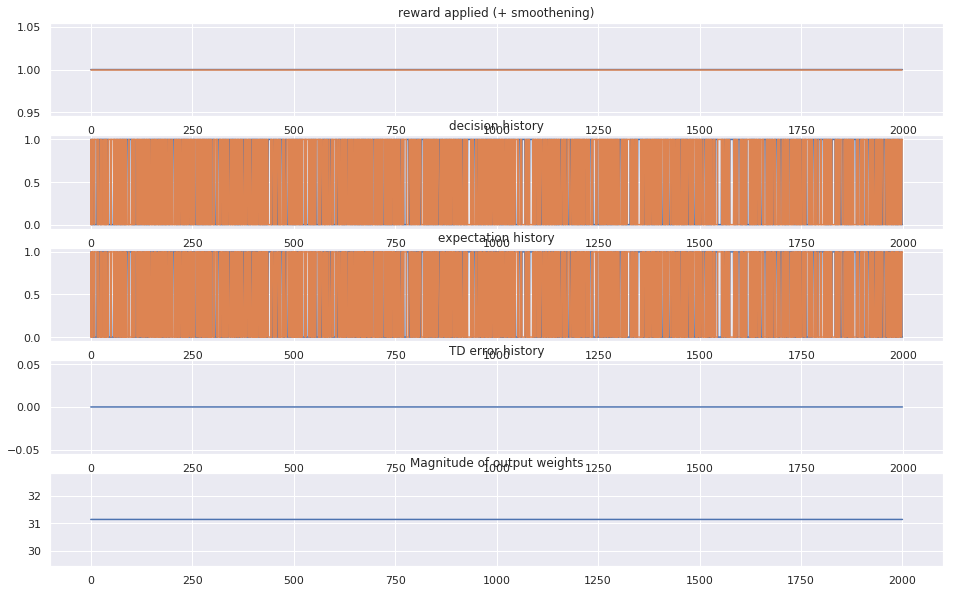

In [453]:
# Plot.
fig, ax = plt.subplots(nrows = 5, figsize=(4*4, 10))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)
ax[4].plot(w_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
ax[4].set_title('Magnitude of output weights')
plt.show()

In [454]:
# Reverse contingency.
r_hist, decision_hist, exp_hist, w_hist = discrete_experiment_v2(
    I, num_trials=num_trials*4, net=net, contingency=I2A_2)

In [455]:
# Post-processing (reversal).

time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

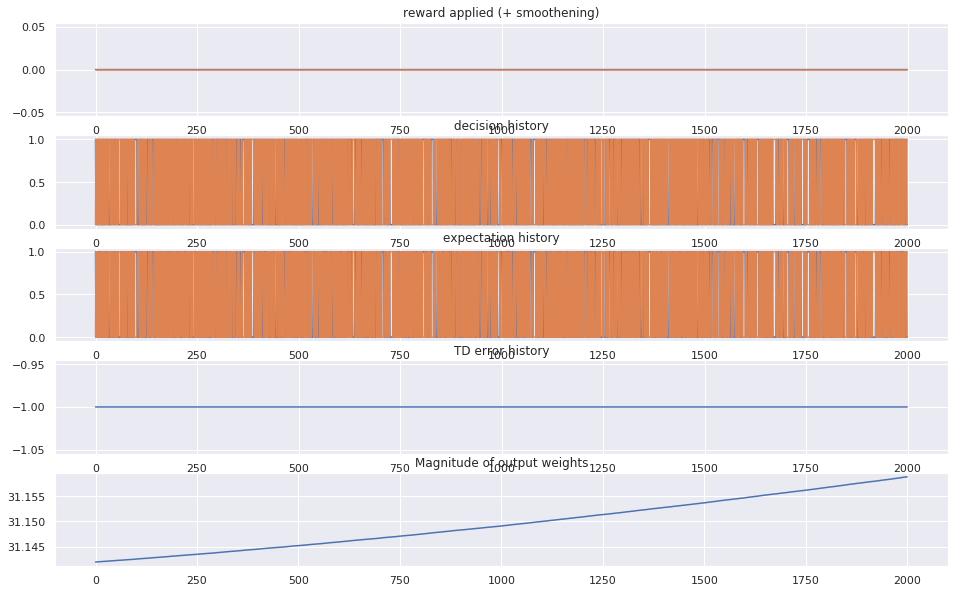

In [456]:
# Plot.
fig, ax = plt.subplots(nrows = 5, figsize=(4*4, 10))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)
ax[4].plot(w_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
ax[4].set_title('Magnitude of output weights')
plt.show()

## Why does the network keep getting stuck at 0?

In [457]:
# Single layer feedforward neural network using OFC paper's equations.
class SingleLayerFeedforwardNet_v1_verbose(SingleLayerFeedforwardNet_v1):
    
    def update_weights(self, r, verbose=False):
        row_vec = self.y - self.params['training threshold']
        col_vec = (r - self.exp_r) * self.z
        delta_w = self.params['learning rate'] * np.outer(row_vec, col_vec)
        self.output_weights += delta_w

        # Normalize weights
        self.output_weights /= np.linalg.norm(self.output_weights)
        if verbose:
            print('reward:', r)
            print('expectation:', self.exp_r)
            print('decision:', self.z)
            print('delta w magnitude', np.linalg.norm(delta_w))
    

In [458]:
# Experiment function.

def debug_experiment_verbose(I, T=1000, num_trials=3000, net=None, contingency=None):
    r_hist = []
    decision_hist = []
    exp_hist = []
    r = 0

    for trial in range(num_trials):
        index = np.random.randint(I.shape[0])
        text_input = I[index]
        exp_output = contingency[index]
        
        decision = 0
        expectation = 0

        for ms in range(T):
            # Initial rest period (0 - 200ms) of trial
            if ms < (T * delay):
                net.step()
                continue

            # Apply input for the trial (200ms - 700ms)
            if 200 <= ms <= 700:
                net.step(text_input)
                continue

            # Measure output of the network (900ms)
            if ms == 900:
                verbose = trial > num_trials * 0.95
                net.step()
                decision, expectation = net.get_output(exp=True)
                r = int(np.array_equal(decision, exp_output))
                net.update_weights(r, verbose=verbose)

                continue
            
            # If nothing needs to happen, move forward a timestep.
            net.step()
      
        r_hist += [r]
        decision_hist += [decision]
        exp_hist += [expectation]
    
    r_hist = np.array(r_hist)
    decision_hist = np.array(decision_hist)
    exp_hist = np.array(exp_hist)
    return r_hist, decision_hist, exp_hist

In [459]:
# Initial learning experiment.

print("Learning rate = 0.001")
net = SingleLayerFeedforwardNet_v1_verbose(reservoir_network_params)
net.params['learning rate'] = 0.001

r_hist, decision_hist, exp_hist = debug_experiment_verbose(
    I, T=1000, num_trials=num_trials, net=net, contingency=I2A_1)

Learning rate = 0.001
reward: 0
expectation: [0.9504834 0.0495166]
decision: [1. 0.]
delta w magnitude 0.0028098363513993645
reward: 0
expectation: [0.00372012 0.99627988]
decision: [0. 1.]
delta w magnitude 0.0033616837851197503
reward: 0
expectation: [0.00368736 0.99631264]
decision: [0. 1.]
delta w magnitude 0.003362043971083722
reward: 0
expectation: [0.95174474 0.04825526]
decision: [1. 0.]
delta w magnitude 0.0028134911738408527
reward: 0
expectation: [0.00360232 0.99639768]
decision: [0. 1.]
delta w magnitude 0.0033617508078071213
reward: 0
expectation: [0.95222142 0.04777858]
decision: [1. 0.]
delta w magnitude 0.002815491630094665
reward: 0
expectation: [0.00352368 0.99647632]
decision: [0. 1.]
delta w magnitude 0.0033623783759252923
reward: 0
expectation: [0.00349809 0.99650191]
decision: [0. 1.]
delta w magnitude 0.003362145660964592
reward: 0
expectation: [0.00347085 0.99652915]
decision: [0. 1.]
delta w magnitude 0.0033629887688578965
reward: 0
expectation: [0.00343952 0.9

In [460]:
# Post-processing.

# Smoothen the reward history curve.
time_filtered = np.arange(0, r_hist.size, 3)
r_filtered = smooth(np.arange(r_hist.size), time_filtered, r_hist, 2)

# Calculate TD error history.
td_hist = r_hist - np.multiply(exp_hist, decision_hist).sum(axis=1)

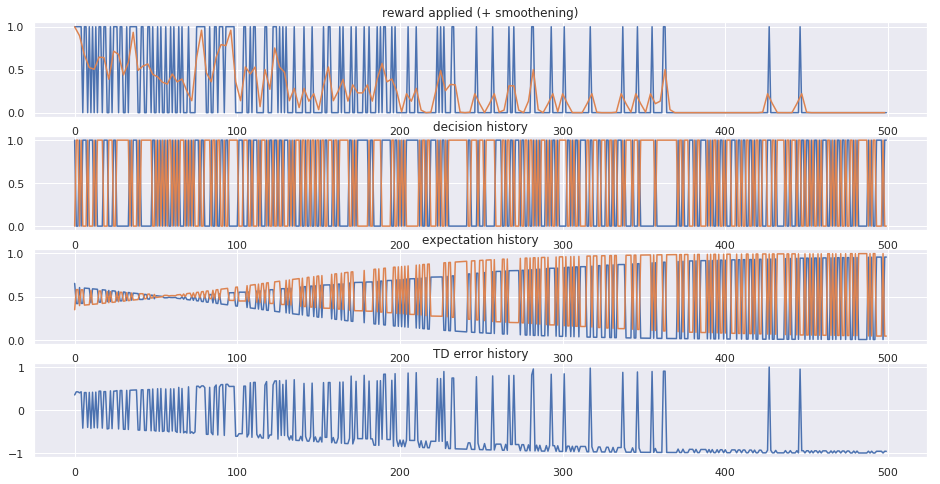

In [461]:
# Plot.
fig, ax = plt.subplots(nrows = 4, figsize=(4*4, 8))
ax[0].plot(r_hist)
ax[0].plot(time_filtered, r_filtered)
ax[1].plot(decision_hist)
ax[2].plot(exp_hist)
ax[3].plot(td_hist)

ax[0].set_title("reward applied (+ smoothening)")
ax[1].set_title("decision history")
ax[2].set_title("expectation history")
ax[3].set_title("TD error history")
plt.show()